<a href="https://colab.research.google.com/github/Piyush01Bhatt/Deep-Learning/blob/master/Chatbot_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip -O /tmp/movie_dialogs.zip

--2019-08-24 11:47:46--  http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.20
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.20|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9916637 (9.5M) [application/zip]
Saving to: ‘/tmp/movie_dialogs.zip’

/tmp/movie_dialogs. 100%[===================>]   9.46M  3.46MB/s    in 2.7s    

2019-08-24 11:47:49 (3.46 MB/s) - ‘/tmp/movie_dialogs.zip’ saved [9916637/9916637]



In [0]:
import zipfile
with zipfile.ZipFile("/tmp/movie_dialogs.zip","r") as zip_ref:
    zip_ref.extractall("/tmp/movie_dialogs")

In [3]:
pip install -q tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 348.9MB 118kB/s 
     |████████████████████████████████| 3.1MB 39.1MB/s 
     |████████████████████████████████| 501kB 48.2MB/s 


In [4]:
import tensorflow as tf
import numpy as np
import re
import time
import os
print(tf.__version__)

2.0.0-beta1


In [0]:
lines = open('/tmp/movie_dialogs/cornell movie-dialogs corpus/movie_lines.txt',
            encoding = 'utf-8', errors='ignore').read().split('\n')
conversations = open('/tmp/movie_dialogs/cornell movie-dialogs corpus/movie_conversations.txt',
            encoding = 'utf-8', errors='ignore').read().split('\n')

In [6]:
print(lines[0])
print(conversations[0])

L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!
u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L194', 'L195', 'L196', 'L197']


In [0]:
# Creating a dictionary that maps each line and its id
id2line = {}
for line in lines:
  _line = line.split(' +++$+++ ')
  if len(_line) == 5:
    id2line[_line[0]] = _line[4]

In [0]:
# Creating a list of all of the conversations
conversations_ids = []
for conversation in conversations[:-1]:
  _conversation = conversation.split(' +++$+++ ')[-1][1:-1].replace("'", "").replace(" ","")
  conversations_ids.append(_conversation.split(','))

In [9]:
print(id2line['L1045'])
print(conversations_ids[0])

They do not!
['L194', 'L195', 'L196', 'L197']


In [0]:
questions = []
answers = []

for ids in conversations_ids:
  for i in range(len(ids)-1):
    questions.append(id2line[ids[i]])
    answers.append(id2line[ids[i+1]])
    

In [11]:
print(f'questions: \n {questions[:5]}')
print(f'answers: \n {answers[:5]}')

questions: 
 ['Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.', "Well, I thought we'd start with pronunciation, if that's okay with you.", 'Not the hacking and gagging and spitting part.  Please.', "You're asking me out.  That's so cute. What's your name again?", "No, no, it's my fault -- we didn't have a proper introduction ---"]
answers: 
 ["Well, I thought we'd start with pronunciation, if that's okay with you.", 'Not the hacking and gagging and spitting part.  Please.', "Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?", 'Forget it.', 'Cameron.']


#**EDA**

In [0]:
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
lengths_of_questions = [len(text) for text in questions]
lengths_of_answers = [len(text) for text in answers]
polarity_questions = [TextBlob(text).sentiment.polarity for text in questions]
polarity_answers = [TextBlob(text).sentiment.polarity for text in answers]
wordcount_questions = [len(text.split(" ")) for text in questions]
wordcount_answers = [len(text.split(" ")) for text in answers]

In [0]:
wordcount_questions = np.array(wordcount_questions)
wordcount_answers = np.array(wordcount_answers)

In [15]:
print(f'Number of sentences with len>250 {len(wordcount_questions[wordcount_questions>250])}')
print(f'Number of sentences with len<250 {len(wordcount_questions[wordcount_questions<250])}')

Number of sentences with len>250 8
Number of sentences with len<250 221608


In [16]:
print(f'Number of answers with len>250 {len(wordcount_answers[wordcount_answers>250])}')
print(f'Number of answers with len<250 {len(wordcount_answers[wordcount_answers<250])}')

Number of answers with len>250 18
Number of answers with len<250 221598


In [17]:
print(f'max len of questions = {max(wordcount_questions)}')
print(f'max len of answers = {max(wordcount_answers)}')

max len of questions = 1121
max len of answers = 1121


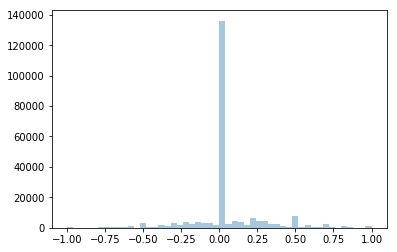

In [18]:
sns.distplot(polarity_questions, bins=50, kde=False)

In [19]:
polarity_questions = np.array(polarity_questions)
print(f'Total negative polarity questions {len(polarity_questions[polarity_questions<0])}')
print(f'Total positive polarity questions {len(polarity_questions[polarity_questions>0])}')
print(f'Total neutral polarity questions {len(polarity_questions[polarity_questions==0])}')

Total negative polarity questions 33702
Total positive polarity questions 53447
Total neutral polarity questions 134467


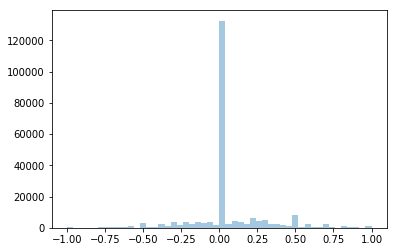

In [20]:
sns.distplot(polarity_answers, bins=50, kde=False)

In [21]:
polarity_answers = np.array(polarity_answers)
print(f'Total negative polarity answers {len(polarity_answers[polarity_answers<0])}')
print(f'Total positive polarity answers {len(polarity_answers[polarity_answers>0])}')
print(f'Total neutral polarity answers {len(polarity_answers[polarity_answers==0])}')

Total negative polarity answers 34304
Total positive polarity answers 56397
Total neutral polarity answers 130915


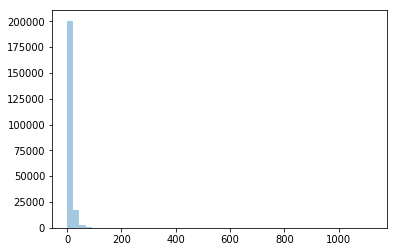

In [22]:
sns.distplot(wordcount_questions,kde=False)

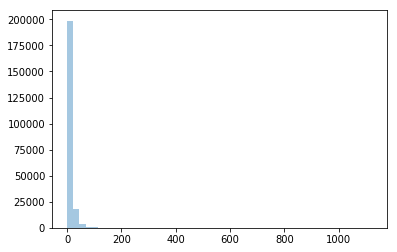

In [23]:
sns.distplot(wordcount_answers,kde=False)

#**Data Cleaning**

In [0]:
def clean_text(text):
  
  text = text.lower()
  text = re.sub(r"i'm","i am", text)
  text = re.sub(r"he's","he is", text)
  text = re.sub(r"she's","she is", text)
  text = re.sub(r"that's","that is", text)
  text = re.sub(r"what's","what is", text)
  text = re.sub(r"where's","where is", text)
  text = re.sub(r"\'ll"," will", text)
  text = re.sub(r"\'ve"," have", text)
  text = re.sub(r"\'d"," would", text)
  text = re.sub(r"\'re"," are", text)
  text = re.sub(r"won't","will not", text)
  text = re.sub(r"can't","cannot", text)
  text = re.sub(r"don't","do not", text)
  text = re.sub(r"[-+(){}#|@=]+","", text)
  text = re.sub(r"([?.!,।])",r" \1 ",text)
  text = re.sub(r'[" "]+', " ", text)
  text = re.sub(r"[^a-zA-Z?.!,]+"," ", text)
  text = text.rstrip().strip()
  text = '<start> ' + text + ' <end>'
 
  return text

In [0]:
clean_questions = []
for ques in questions:
  clean_questions.append(clean_text(ques))

In [0]:
clean_answers = []
for ans in answers:
  clean_answers.append(clean_text(ans))

In [27]:
print(clean_questions[0:5])

['<start> can we make this quick ? roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad . again . <end>', '<start> well , i thought we would start with pronunciation , if that is okay with you . <end>', '<start> not the hacking and gagging and spitting part . please . <end>', '<start> you are asking me out . that is so cute . what is your name again ? <end>', '<start> no , no , it s my fault we didn t have a proper introduction <end>']


In [0]:
wordcount_clean_ques = np.array([len(text.split(" ")) for text in clean_questions])
wordcount_clean_ans = np.array([len(text.split(" ")) for text in clean_answers])

In [29]:
print(f'max len of questions = {max(wordcount_clean_ques)}')
print(f'max len of answers = {max(wordcount_clean_ans)}')

max len of questions = 390
max len of answers = 740


In [45]:
print(f'Number of sentences with len>0 {len(wordcount_clean_ques[(wordcount_clean_ques>10) & (wordcount_clean_ques<50)])}')
print(f'Number of sentences with len<50 {len(wordcount_clean_ques[wordcount_clean_ques<20])}')

Number of sentences with len>0 111419
Number of sentences with len<50 170813


In [44]:
print(f'Number of answers with len>250 {len(wordcount_clean_ans[wordcount_clean_ans>10])}')
print(f'Number of answers with len<250 {len(wordcount_clean_ans[wordcount_clean_ans<20])}')

Number of answers with len>250 119898
Number of answers with len<250 167669


In [0]:
clean_questions = np.array(clean_questions)
clean_answers = np.array(clean_answers)

In [0]:
mask = wordcount_clean_ans < 20
clean_questions = clean_questions[mask]
clean_answers = clean_answers[mask]

In [48]:
len(clean_questions)

167669

In [0]:
wordcount_clean_ques2 = np.array([len(text.split(" ")) for text in clean_questions])

In [0]:
mask2 = wordcount_clean_ques2 < 20
clean_questions = clean_questions[mask2]
clean_answers = clean_answers[mask2]

In [51]:
len(clean_questions)

129512

#**Tokenization**

In [0]:
word_count = {}

for ques in questions:
  for word in ques.split(" "):
    if word in word_count:
      word_count[word] += 1
    else:
      word_count[word] = 1

for ans in answers:
  for word in ans.split(" "):
    if word in word_count:
      word_count[word] += 1
    else:
      word_count[word] = 1

In [53]:
len(word_count)

164255

In [0]:
lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',oov_token = '<oov>')
lang_tokenizer.fit_on_texts(np.concatenate((clean_questions, clean_answers), axis=0))

In [62]:
vocab = lang_tokenizer.word_index
len(vocab)

31814

In [55]:
ques_tensor = lang_tokenizer.texts_to_sequences(clean_questions)
ques_tensor = tf.keras.preprocessing.sequence.pad_sequences(ques_tensor,padding='post')
print(ques_tensor[0:1])

[[    3    61     7     8   134    25    51   351    47 21818     7    76
     18    12    84    47     6     2     4]]


In [56]:
len(ques_tensor[0])

19

In [57]:
ques_tensor_shape = ques_tensor.shape
print(ques_tensor_shape)

(129512, 19)


In [58]:
ans_tensor = lang_tokenizer.texts_to_sequences(clean_answers)
ans_tensor = tf.keras.preprocessing.sequence.pad_sequences(ans_tensor,padding='post')
print(ans_tensor[0:1])

[[    3    17     9  6906    29 12263    29  8977   473     2   137     2
      4     0     0     0     0     0     0]]


In [59]:
len(ans_tensor[0])

19

In [64]:
ans_tensor_shape = ans_tensor.shape
print(ans_tensor_shape)

(129512, 19)


In [0]:
rev_word_index = {v:k for k,v in vocab.items()}

In [0]:
BUFFER_SIZE = len(ques_tensor)
BATCH_SIZE = 32
steps_per_epoch = len(ques_tensor)//BATCH_SIZE
embedding_dim = 64
units = 128
vocab_input_size = len(vocab)+1
vocab_tar_size = len(vocab)+1

dataset = tf.data.Dataset.from_tensor_slices((ques_tensor,ans_tensor)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [67]:
ex_inp_batch, ex_tar_batch = next(iter(dataset))
ex_inp_batch.shape, ex_tar_batch.shape

(TensorShape([32, 19]), TensorShape([32, 19]))

#**Encoder Decoder with Attention(Bahdanau)**

##**Encoder**

In [0]:
class Encoder(tf.keras.Model):

  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru1 = tf.keras.layers.GRU(self.enc_units,return_sequences = True,recurrent_initializer = 'glorot_uniform')
    #self.gru2 = tf.keras.layers.GRU(self.enc_units,return_sequences = True,recurrent_initializer = 'glorot_uniform')
    #self.gru3 = tf.keras.layers.GRU(self.enc_units,return_sequences = True,recurrent_initializer = 'glorot_uniform')
    self.gru4 = tf.keras.layers.GRU(self.enc_units,return_sequences = True,return_state = True,recurrent_initializer = 'glorot_uniform')
    
  def call(self, x, hidden):
    x = self.embedding(x)
    x = self.gru1(x, initial_state = hidden)
    #x = self.gru2(x)
    #x = self.gru3(x)
    output,state = self.gru4(x)
    return output, state
    
  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [69]:
encoder = Encoder(vocab_input_size, embedding_dim, units, BATCH_SIZE)

# SAMPLE INPUT
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(ex_inp_batch, sample_hidden)

print (f'Encoder output shape: (batch size, sequence length, units) {sample_output.shape}')
print (f'Encoder Hidden state shape: (batch size, units) {sample_hidden.shape}')

Encoder output shape: (batch size, sequence length, units) (32, 19, 128)
Encoder Hidden state shape: (batch size, units) (32, 128)


##**Attention**

In [0]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention,self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)
  
  def call(self, query, values):
    hidden_with_time_axis = tf.expand_dims(query,1) # dimension == (batch,1,hidden_size)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)
    ))
    attention_weights = tf.nn.softmax(score, axis=1) # dimension = (batch, max_seq_length, 1)

    context_vector = attention_weights * values  # dimension = (batch, max_seq_length,hidden_size)
    context_vector = tf.reduce_sum(context_vector, axis=1) #dimension = (batch, hidden_size)

    return context_vector, attention_weights

In [71]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (32, 128)
Attention weights shape: (batch_size, sequence_length, 1) (32, 19, 1)


##**Decoder**

In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder,self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru1 = tf.keras.layers.GRU(self.dec_units,return_sequences = True,recurrent_initializer = 'glorot_uniform')
    #self.gru2 = tf.keras.layers.GRU(self.dec_units,return_sequences = True,recurrent_initializer = 'glorot_uniform')
    #self.gru3 = tf.keras.layers.GRU(self.dec_units,return_sequences = True,recurrent_initializer = 'glorot_uniform')
    self.gru4 = tf.keras.layers.GRU(self.dec_units,return_sequences = True,return_state = True,recurrent_initializer = 'glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    context_vector, attention_weights = self.attention(hidden, enc_output)
    x = self.embedding(x) # dims_out = (batch, 1, embedding_dims)
    x = tf.concat([tf.expand_dims(context_vector, axis=1),x], axis=-1)
    x = self.gru1(x)
    #x = self.gru2(x)
    #x = self.gru3(x)
    output,state = self.gru4(x)
    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))
    # output shape == (batch_size, vocab)
    x = self.fc(output)
    return x, state, attention_weights

In [73]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((32, 1)),
                                      sample_hidden, sample_output)

print (f'Decoder output shape: (batch_size, vocab size) {sample_decoder_output.shape}')

Decoder output shape: (batch_size, vocab size) (32, 31815)


#**Training**

##**Optimiser and Loss functions**

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

##**Creating Checkpoint**

In [0]:
checkpoint_dir = '/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

##**Custom training using Gradient Tape**

In [0]:
@tf.function
def train_step(inp,tar,enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp,enc_hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([vocab['<start>']]*BATCH_SIZE,1)
    for t in range(1, tar.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(tar[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(tar[:, t], 1)
    
    batch_loss = (loss / int(tar.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [77]:
EPOCHS = 3

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 200 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.4506
Epoch 1 Batch 20 Loss 3.6493
Epoch 1 Batch 40 Loss 2.5771
Epoch 1 Batch 60 Loss 2.8544
Epoch 1 Batch 80 Loss 2.3769
Epoch 1 Batch 100 Loss 2.8460
Epoch 1 Batch 120 Loss 2.1686
Epoch 1 Batch 140 Loss 2.5521
Epoch 1 Batch 160 Loss 2.6798
Epoch 1 Batch 180 Loss 2.3241
Epoch 1 Batch 200 Loss 1.8703
Epoch 1 Batch 220 Loss 2.4333
Epoch 1 Batch 240 Loss 2.3488
Epoch 1 Batch 260 Loss 2.4345
Epoch 1 Batch 280 Loss 2.3692
Epoch 1 Batch 300 Loss 2.2824
Epoch 1 Batch 320 Loss 2.2667
Epoch 1 Batch 340 Loss 1.9657
Epoch 1 Batch 360 Loss 2.3611
Epoch 1 Batch 380 Loss 2.2284
Epoch 1 Batch 400 Loss 2.5678
Epoch 1 Batch 420 Loss 2.6240
Epoch 1 Batch 440 Loss 2.0561
Epoch 1 Batch 460 Loss 2.3567
Epoch 1 Batch 480 Loss 2.1303
Epoch 1 Batch 500 Loss 2.8329
Epoch 1 Batch 520 Loss 2.3910
Epoch 1 Batch 540 Loss 2.1006
Epoch 1 Batch 560 Loss 2.6414
Epoch 1 Batch 580 Loss 2.5829
Epoch 1 Batch 600 Loss 2.5536
Epoch 1 Batch 620 Loss 2.4913
Epoch 1 Batch 640 Loss 2.3187
Epoch 1 Batch 66

In [0]:
max_length_inp = 19
max_length_targ = 19

def evaluate(sentence):
    sentence = clean_text(sentence)

    inputs = [vocab[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([vocab['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += rev_word_index[predicted_id] + ' '

        if rev_word_index[predicted_id] == '<end>':
            return result, sentence

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence

In [0]:
def respond(sentence):
    result, sentence = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

In [83]:
respond('hello')

Input: <start> hello <end>
Predicted translation: i am not going to be a little . <end> 


In [85]:
respond('what a beautiful day')

Input: <start> what a beautiful day <end>
Predicted translation: i am not going to be a little . <end> 


In [86]:
respond('make this quick')

Input: <start> make this quick <end>
Predicted translation: i am not going to be a little . <end> 


In [88]:
clean_questions[0]

'<start> well , i thought we would start with pronunciation , if that is okay with you . <end>'

In [89]:
respond('well , i thought we would start with pronunciation , if that is okay with you')

Input: <start> well , i thought we would start with pronunciation , if that is okay with you <end>
Predicted translation: i am not going to be a little . <end> 
